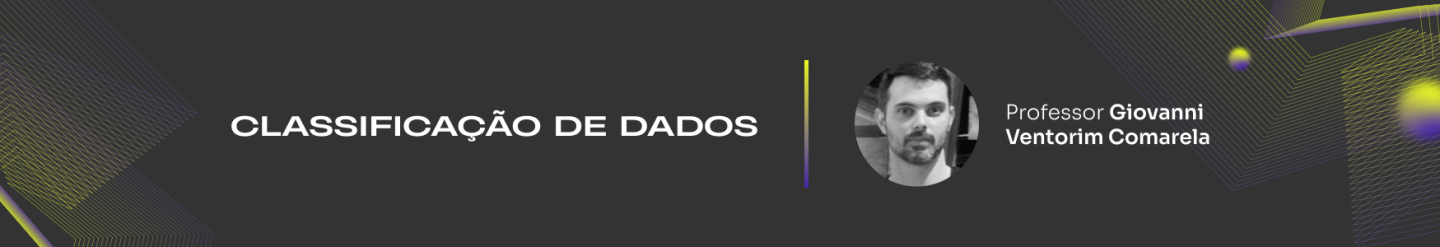

# Validação Cruzada e Seleção de Hiperparâmetros

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Principais desafios experimentais

1. Como avaliar um classificador? **[Aulas passadas]**
2. Como escolher bons hiperparâmetros e evitar *overfitting*? **[Aula de hoje]**

## Questões de hoje

**Entrada:**
  - Um conjunto de dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$
  - Um algoritmo de aprendizado $\mathcal{A}$ que depende de hiperparâmetros $\{\theta_1, \dots, \theta_r\}$
  >- Por exemplo, $\mathcal{A}$ pode ser o KNN e o conjunto de hiperparâmetros pode ser $\{k\}$.

**Saída**
- Um modelo de classificação bem treinado
>- Que tenha sido treinado com hiperparâmetros adequados
>- Que não sofra de *overfitting*

### Visualizando algumas situações interessantes...

### Exemplo I - Impacto do valor de $k$ para o KNN

Considere o conjunto de dados apresentado na figura abaixo. Há **duas características** (``A`` e ``B``) e três classes (``Vermelho``, ``Azul`` e ``Verde``).

Esse exemplo já foi utilizado em nossas aulas sobre KNN e desafios em Classificação.

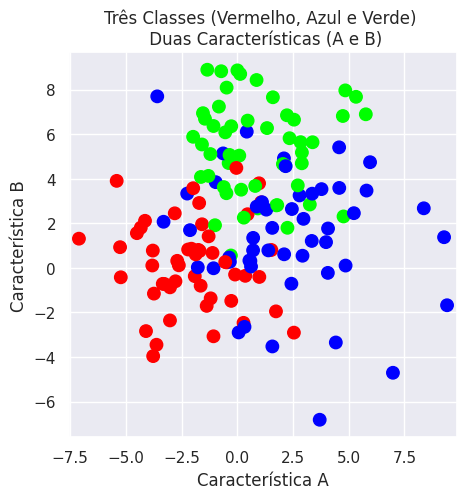

In [ ]:
#@title

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
import seaborn as sns
sns.set()


import sklearn.datasets as sk_data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

X, y = sk_data.make_blobs(n_samples=150,
                          centers=[[-2, 0],[1, 5], [2.5, 1.5]],
                          cluster_std = [2, 2, 3],
                          n_features=2,
                          center_box=(-10.0, 10.0),random_state=0)
plt.figure(figsize = (5,5))
plt.axis('equal')
plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold, s = 80);

plt.xlabel('Característica A')
plt.ylabel('Característica B')
plt.title('Três Classes (Vermelho, Azul e Verde) \n Duas Características (A e B)');

Se variarmos o valor de $k$, haverá impacto nos resultados das classificações?

Para responder a essa pergunta, vamos observar o que ocorre com as **regiões de decisão** para vários valores de $k$.

A figura abaixo apresenta as regiões de decisão para $k = 25$.

Em outras palavras, pontos a serem classificados que estiverem na região verde, serão classificados com sendo da classe ``Verde``. De forma análoga, o mesmo vale para pontos que estiverem nas regiões azul e vermelha.

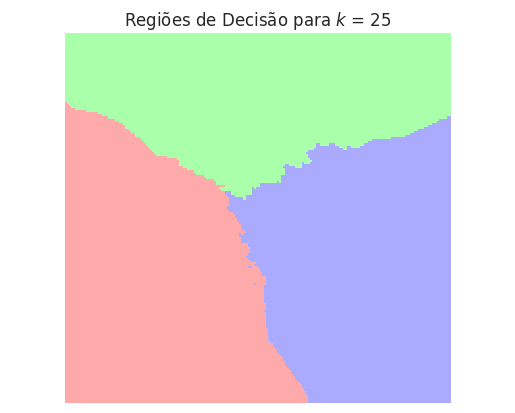

In [ ]:
#@title
from sklearn.neighbors import KNeighborsClassifier

h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

k = 25
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap = cmap_light, shading = 'auto')
plt.axis('equal')
plt.axis('off')
plt.title(f'Regiões de Decisão para $k$ = {k}');

Vejamos o que acontece para outros valores de $k$.

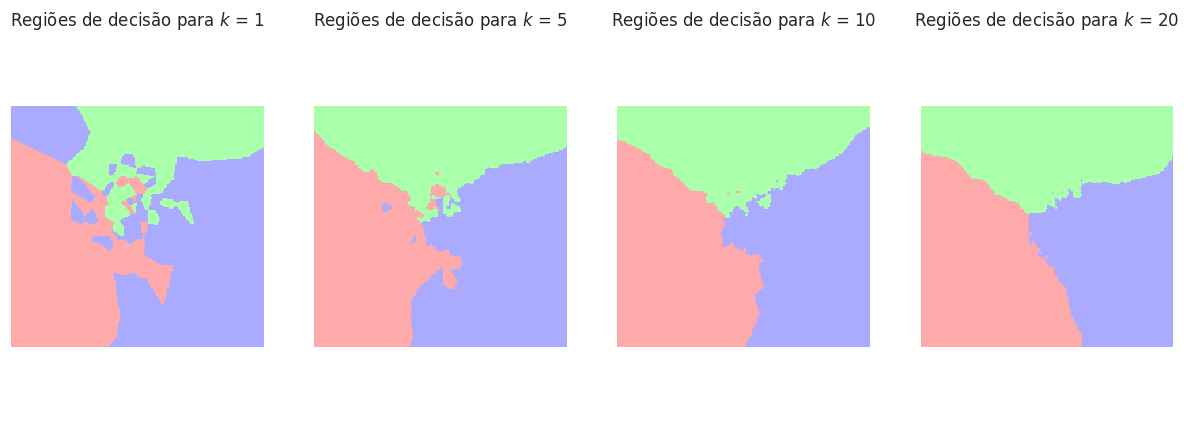

In [ ]:
#@title
from sklearn.neighbors import KNeighborsClassifier


h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

f, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, k in enumerate([1, 5, 10, 20]):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X, y)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i].pcolormesh(xx, yy, Z, cmap = cmap_light, shading = 'auto')
    axs[i].axis('equal')
    axs[i].axis('off')
    axs[i].set_title(f'Regiões de decisão para $k$ = {k}');

Pelos resultados obtidos, podemos perceber que a escolha de $k$ impacta muito no funcionamento dos classificadores obtidos!

Essas diferenças podem ser observadas com as métricas de avaliação vistas nas aulas passadas?

Vamos analisar essa situação com um conjunto de dados mais simples.


### Exemplo II - Impacto do valore de $k$ para o KNN




Considere o conjunto de dados abaixo.

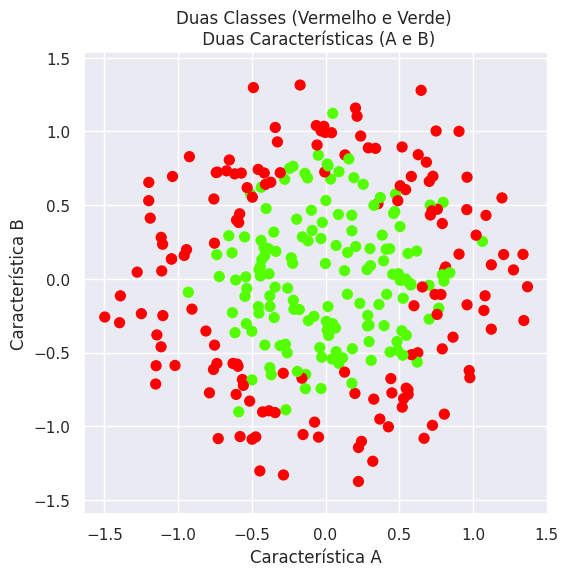

In [ ]:
#@title
import sklearn.datasets as datasets
sns.set()

X, y = datasets.make_circles(n_samples = 300, noise=.2, factor=.5, random_state=1)

plt.figure(figsize = (6,6))
plt.prism()  # this sets a nice color map
plt.scatter(X[:, 0], X[:, 1], c=y, s = 50)
plt.axis('equal');

plt.xlabel('Característica A')
plt.ylabel('Característica B')
plt.title('Duas Classes (Vermelho e Verde) \n Duas Características (A e B)');

In [ ]:
#@title
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score
from  matplotlib.colors import LinearSegmentedColormap

def evaluate_knn(k, X_train, X_test, y_train, y_test):

  fig_size = (12, 5)

  x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
  y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
  plot_step = 0.01
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train, y_train)
  y_pred_train = knn.predict(X_train)
  y_pred_test = knn.predict(X_test)

  Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

  plt.figure(figsize = fig_size)
  plt.subplot(1, 2, 1)
  cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)
  plt.axis('equal')
  plt.axis('off')
  plt.xlim((x_min, x_max))
  plt.ylim((y_min, y_max))
  plt.title('%d-NN - Conjunto de Treinamento\nAcurácia: %.2f\nF1-Score: %.2f' % (k, knn.score(X_train, y_train), f1_score(y_train, knn.predict(X_train))));

  plt.subplot(1, 2, 2)
  cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30)
  plt.axis('equal')
  plt.axis('off')
  plt.xlim((x_min, x_max))
  plt.ylim((y_min, y_max))
  plt.title('%d-NN - Conjunto de Teste\nAcurácia: %.2f\nF1-Score: %.2f' % (k, knn.score(X_test, y_test), f1_score(y_test, knn.predict(X_test))));

Vamos fazer a divisão dos dados em conjuntos de treinamento e teste.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 42)

Vamos observar as regiões de decisão e métricas de desempenho do KNN para diversos valores de $k$.

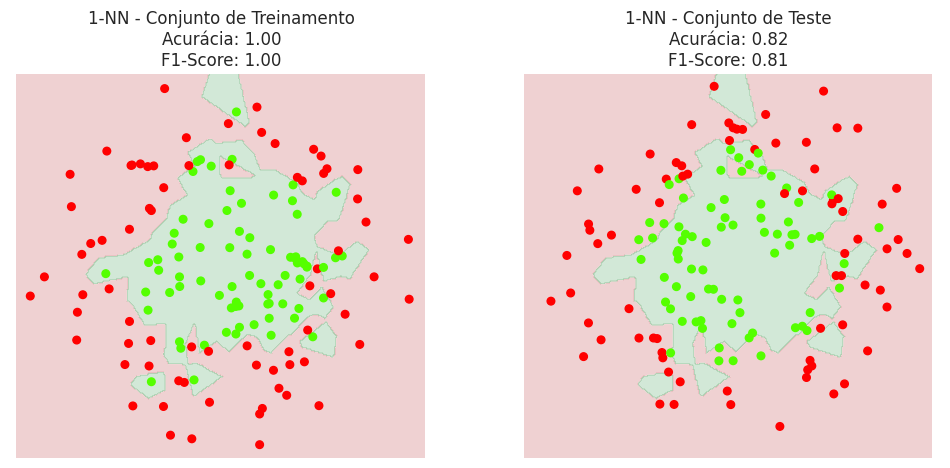

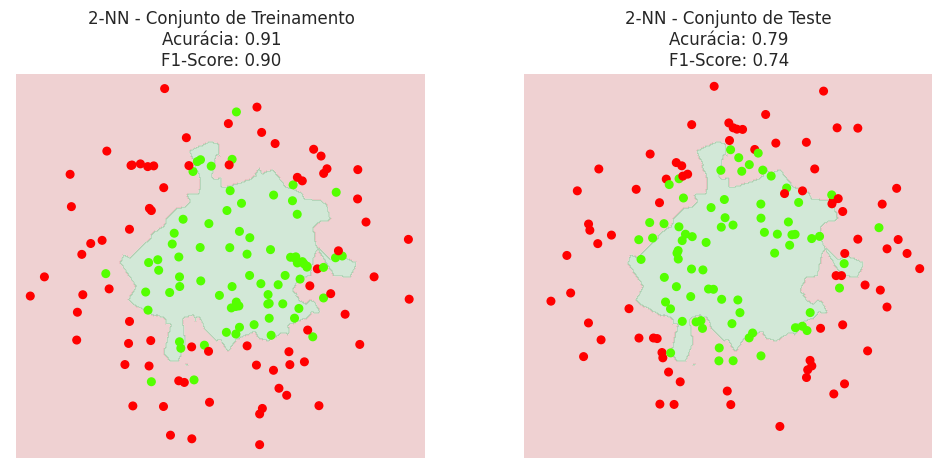

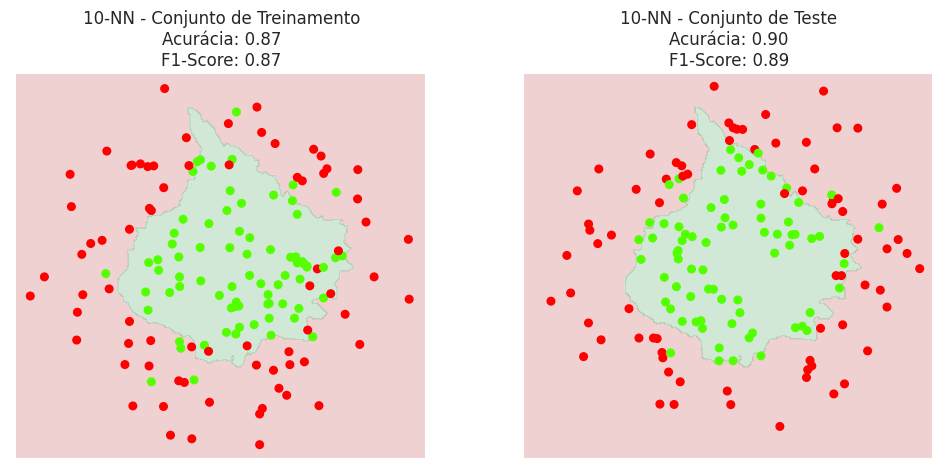

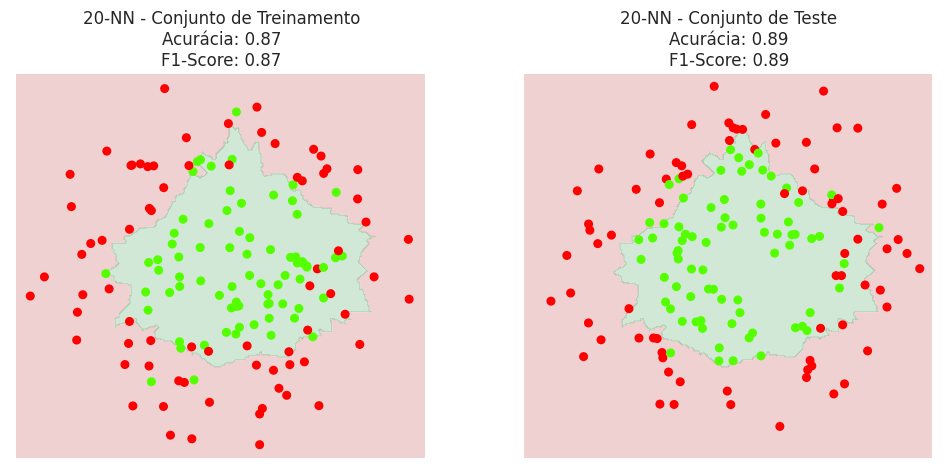

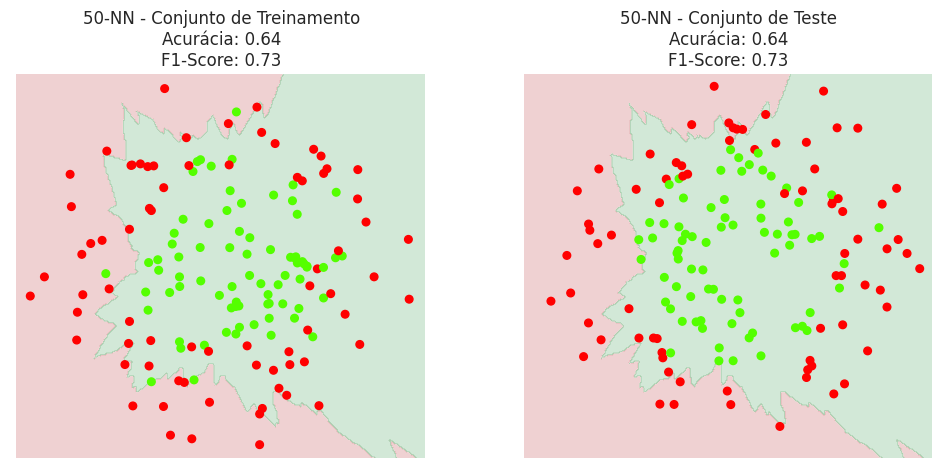

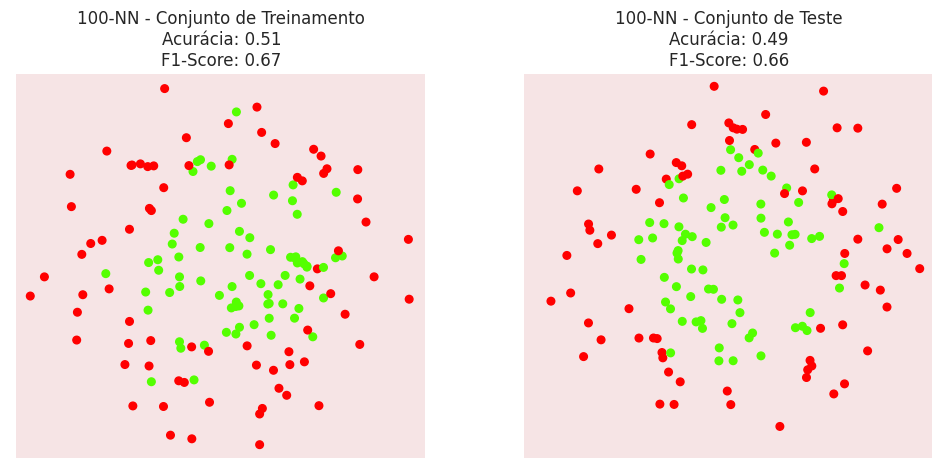

In [ ]:
k_values = [1, 2, 10, 20, 50, 100]

for k in k_values:
  evaluate_knn(k, X_train, X_test, y_train, y_test)

Do exemplo acima, pode-se ver que:
- Valores muito pequenos de $k$ tendem a gerar classificadores muito bons para o conjunto de treinamento, mas que não são capazes de manter o mesmo desempenho para o conjunto de teste. Esse fenômeno é conhecido como **overfitting**!
- Por outro lado, valores muito grandes tendem a gerar classificadores pobres (ruins tanto para o conjunto de treinamento quanto para o de teste).

Como escolher o $k$ que evita esses dois problemas então?

### Exemplo III - Árvore de Decisão

O próximo exemplo ilustra a mesma situação com relação a uma árvore de decisão.

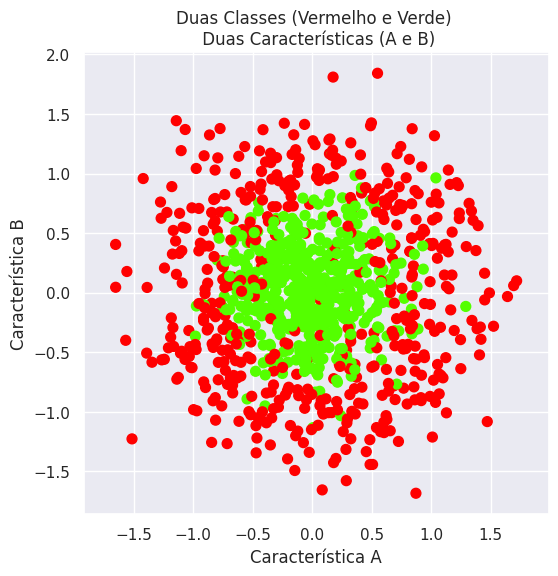

In [ ]:
#@title
import sklearn.datasets as datasets
sns.set()

X, y = datasets.make_circles(n_samples = 1000, noise=.3, factor=.3, random_state=1)

plt.figure(figsize = (6,6))
plt.prism()  # this sets a nice color map
plt.scatter(X[:, 0], X[:, 1], c=y, s = 50)
plt.axis('equal');

plt.xlabel('Característica A')
plt.ylabel('Característica B')
plt.title('Duas Classes (Vermelho e Verde) \n Duas Características (A e B)');

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 42)

In [ ]:
import sklearn.tree as tree
dtc = tree.DecisionTreeClassifier(max_depth = 15, random_state = 42) # 15, 5, 4, 3

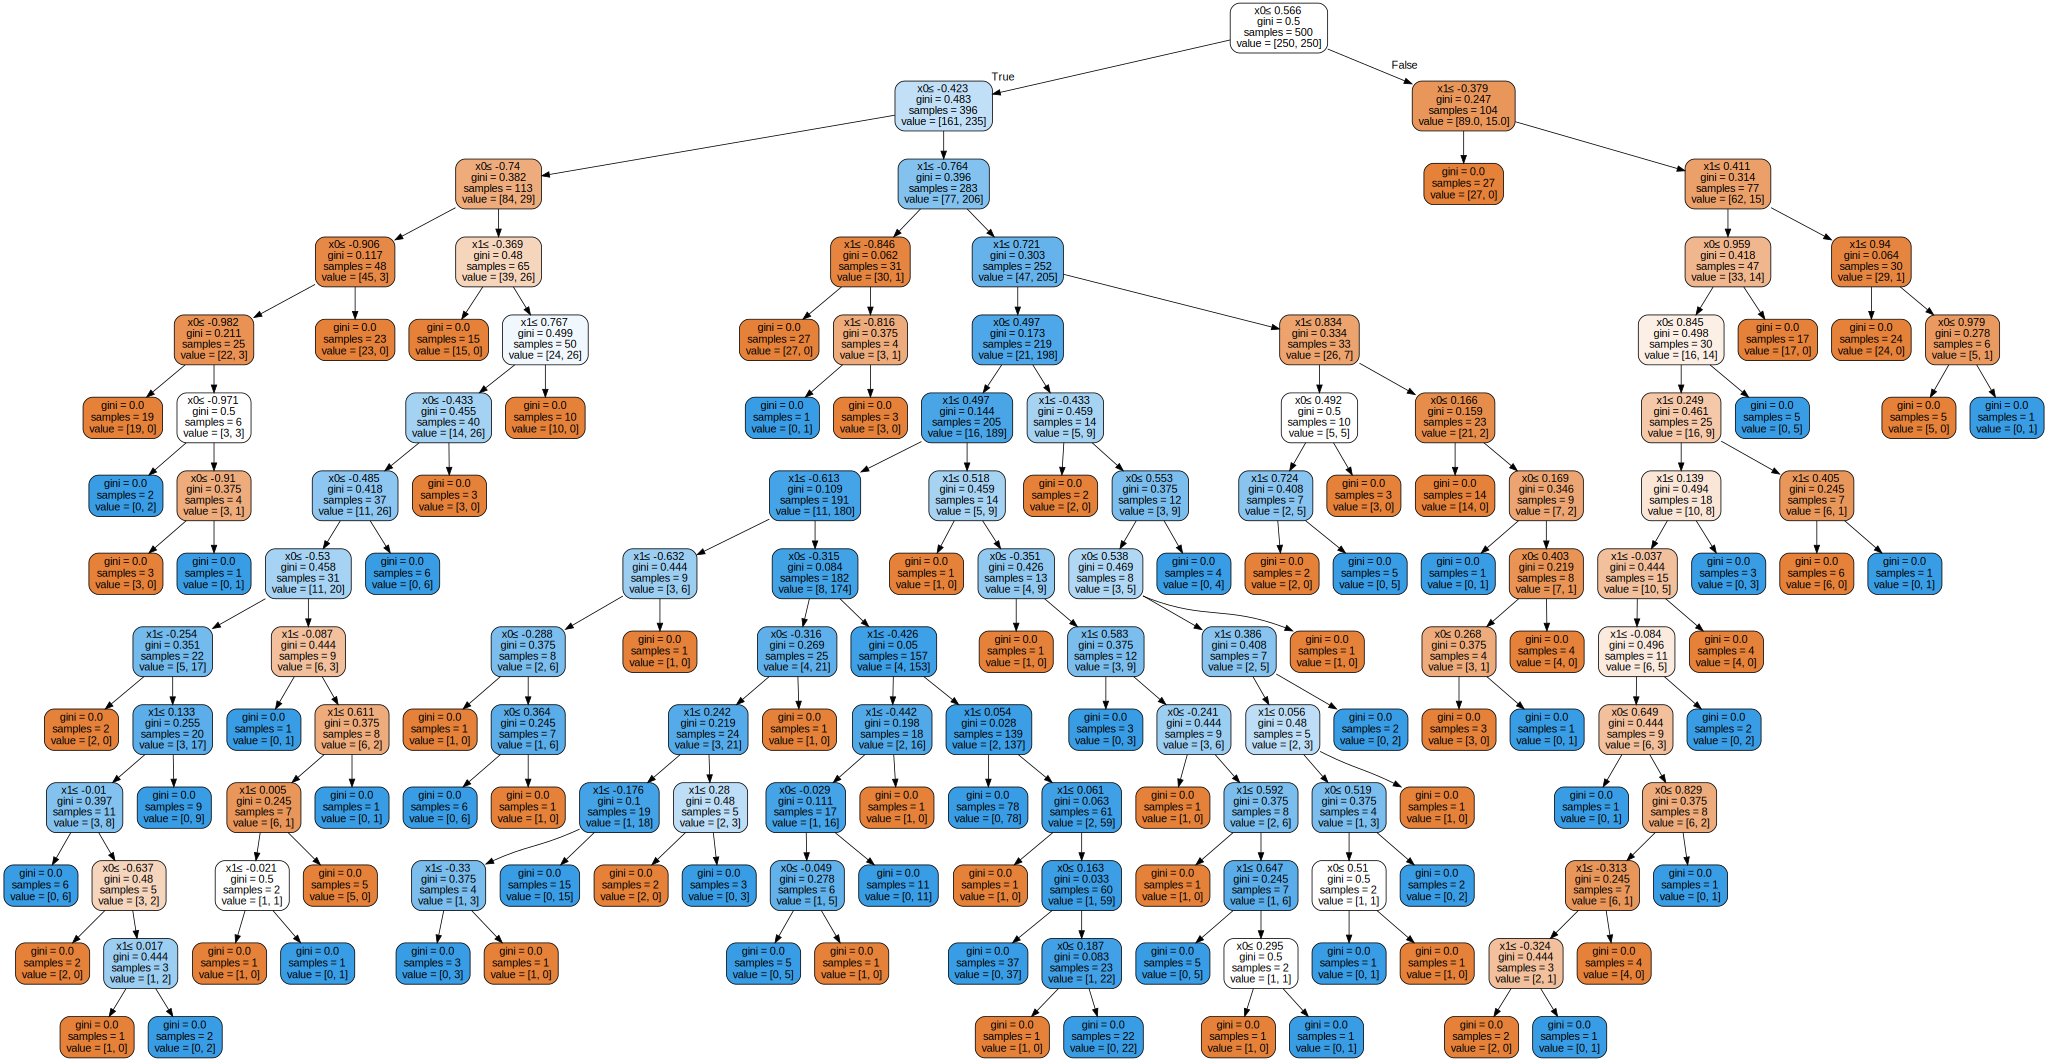

In [ ]:
#@title
import graphviz
import pydotplus

dtc.fit(X_train,y_train);

dot_data = tree.export_graphviz(dtc, out_file=None,
                     filled=True, rounded=True,
                     special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("dt-vis",view = True)
graph

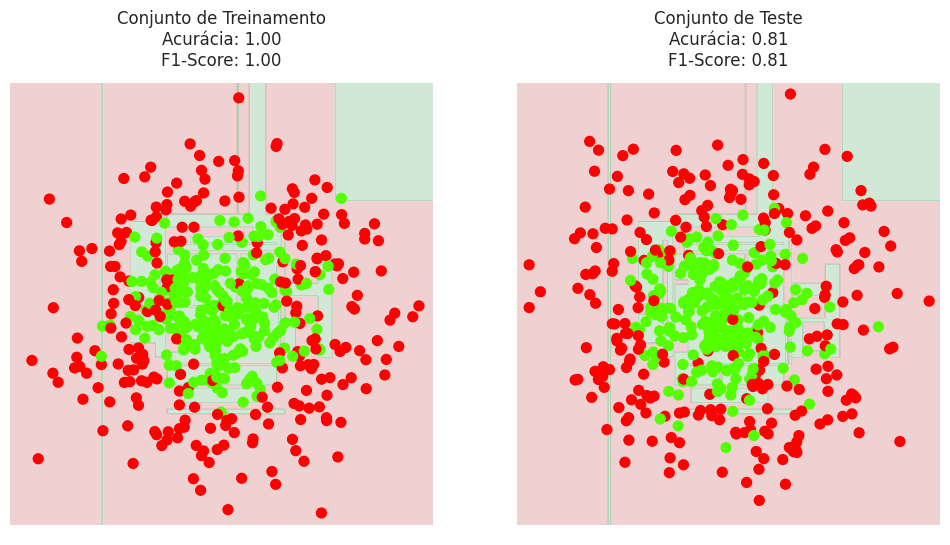

In [ ]:
#@title

x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

plot_step = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 50)
plt.axis('equal')
plt.axis('off')
#plt.xlim((x_min, x_max))
#plt.ylim((y_min, y_max))
plt.title('Conjunto de Treinamento\nAcurácia: %.2f\nF1-Score: %.2f' % (dtc.score(X_train, y_train), f1_score(y_train, dtc.predict(X_train))));

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 50)
plt.axis('equal')
plt.axis('off')
#plt.xlim((x_min, x_max))
#plt.ylim((y_min, y_max))
plt.title('Conjunto de Teste\nAcurácia: %.2f\nF1-Score: %.2f' % (dtc.score(X_test, y_test), f1_score(y_test, dtc.predict(X_test))));


De forma similar ao exemplo do KNN, do exemplo acima, pode-se ver que:
- Árvores muito grandes tendem a gerar classificadores muito bons para o conjunto de treinamento, mas que não são capazes de manter o mesmo desempenho para o conjunto de teste. Novamente, temos **overfitting**!
- Por outro lado, árvores muito pequenas tendem a gerar classificadores pobres (ruins tanto para o conjunto de treinamento quanto para o de teste).

Como escolher o tamanho da árvore de maneira adequada?

## Escolhendo hiperparâmetros

Dos exemplos anteriores, pode-se perceber que **escolher os hiperparâmetros de um classificador** é importante para:
- Ter um classificador adequado, de acordo com várias métricas de avaliação;
- Evitar *overfitting*.

Há na literatura várias técnicas para guiar o processo de escolha de hiperparâmetros. Hoje veremos uma das mais populares.

Voltando ao nosso problema original. Nossa entrada é:
  - Um conjunto de dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$
  - Um algoritmo de aprendizado $\mathcal{A}$ que depende de hiperparâmetros $\{\theta_1, \dots, \theta_r\}$

### Passo 1 - Separando o conjunto de testes

Vamos reter, aleatoriamente uma porção do conjunto $D$ para testes. É comum que o conjunto de testes tenha aproximadamente 25% do conjunto de dados.

Assim, o conjunto de testes é denominado $D_{\text{test}}$ e o restando, que utilizaremos para treinamento, é denominado $D_{\text{train}}$.

**IMPORTANTE:** É extremamente importante que durante o projeto/treinamento de um classificador, **NENHUMA** informação de $D_{\text{test}}$ seja utilizada! Caso contrário, estaremos correndo risco de *overfitting*.

### Passo 2 - *$K$-Fold cross-validation*

Após reter o conjunto de teste, fazemos uma nova divisão do conjunto de treinamento em $K$ partes (denominadas *folds*). Esses *folds* serão utilizados para fazer a escolha de **hiperparâmetros**.

A Figura abaixo (Fonte: [``scikit-learn``](https://scikit-learn.org/stable/modules/cross_validation.html)) ilustra como o conjunto de dados deve ser dividido para o caso de $K = 5$.

**IMPORTANTE:** durante o processo de validação cruzada para a escolha de hiperparâmetros o conjunto de teste, $D_{\text{test}}$, não deve ser utilizado para absolutamente nada!

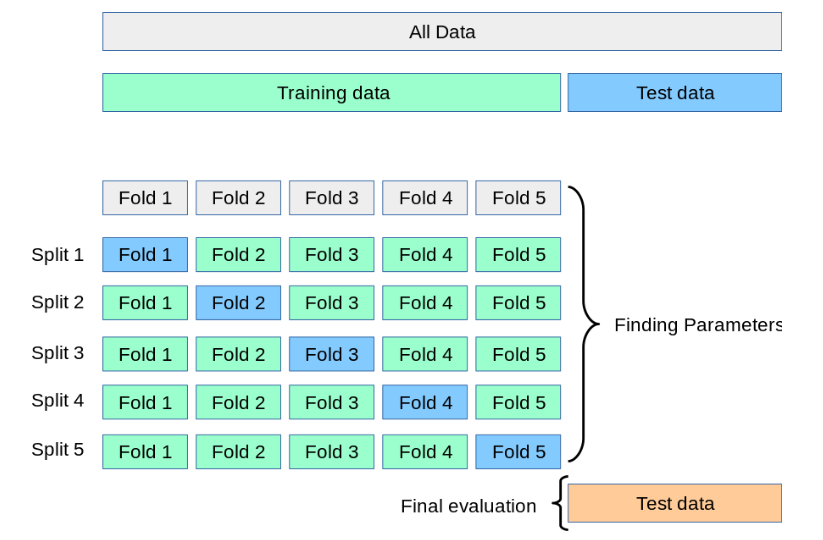

- A ideia da validação cruzada é reter um dos *folds*.
Os $K-1$ *folds* restantes são utilizados para realizar o treinamento do classificador. O *fold* retido é utilizado para avaliar/validar o classificador.

- É realizada uma rotação dos *folds* de treinamento e validação.

- Em cada iteração, para um dado classificador, diferentes configurações de hiperparâmetros são utilizadas para treinamento. Cada classificador obtido é avaliado no *fold* de validação, computando-se, por exemplo, a acurácia.

- As médias das acurácias em todos os *folds* são calculadas para cada variação de classificador.

- Os hiperparâmetros que derem origem à melhor acurácia média são escolhidos como os hiperparâmetros adequados para o problema de classificação.



O algoritmo abaixo apresenta o processo de escolha. No algoritmo, vamos considerar que $\Theta$ é um conjunto de valores candidatos para os hiperparâmetros do algoritmo sendo usado.

1. Embaralhe o conjunto $D_{\text{train}}$
2. $D_1, \dots, D_K ←$ particione $D_{\text{train}}$ em $K$ partes de tamanhos iguais (aproximadamente)
3. **Para cada** $\mathbf{\theta} \in \Theta$
4. >**Para** $i ← 1$ **até** $K$
5. >>$M_{\mathbf{\theta}, i} ←$ Treine o classificador $\mathcal{A}$ com os dados $D_{\text{train}}∖D_i$ e hiperparâmetro $\mathbf{\theta}$
6. >>$a_{\mathbf{\theta}, i}←$ Compute a acurácia do classificador treinado em $D_i$
7. > $a_{\mathbf{\theta}}←\frac{1}{K}\sum_{i = 1}^Ka_{\mathbf{\theta}, i}$
8. $\mathbf{\theta}_{\text{best}}←\arg\max_{\mathbf{\theta} \in \Theta}a_{\mathbf{\theta}}$
9. $M←$ Retreine o classificador usando $\mathcal{A}$ em $D_{\text{train}}$ e $\mathbf{\theta}_{\text{best}}$
10. **Retorne** $M$

**Observação:** ao invés da acurácia, pode-se utilizar outra métrica para avaliar o classificador no *fold* de validação. A escolha da métrica depende muito do problema em questão.

Uma vez que os melhores hiperparâmetros são escolhidos e o classificador é retreinado com esses hiperparâmetros no conjunto de treinamento completo, o classificador pode ser testado e avaliado no conjunto de teste.

A figura abaixo (fonte: [``scikit-learn``](https://scikit-learn.org/stable/modules/cross_validation.html)) exemplifica o processo como um todo.

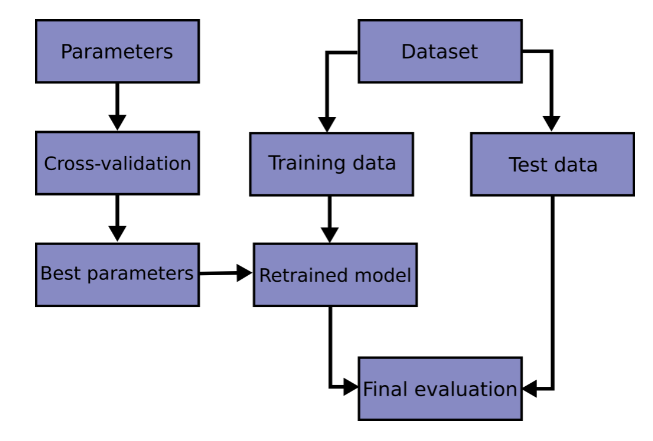

Além de *$K$-Fold Cross-Validation*, há uma grande variedade de técnicas (relacionadas e similares) para escolher hiperparâmetros e evitar *overfitting*. Um tutorial com vários exemplos é apresentado na documentação da ``scikit-learn``.

## Um exemplo prático - KNN

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y = True, as_frame = True)
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Passo 1, separando conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Conjunto de hiperparâmetros candidatos

In [ ]:
params = {'n_neighbors': np.arange(1, 31)}
params

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}

Observe que as colunas da matriz de dados têm ordens de grandeza diferentes. É uma boa prática, pré-processar os dados. Assim, podemos, por exemplo, aplicar a transformação por reescala.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

A classe ``GridSearchCV`` executa o algoritmo discutido anteriormente e nos retorna o melhor modelo. Por padrão, é utilizado um *5-fold Cross-Validation*.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(KNeighborsClassifier(), params, n_jobs = -1)
clf.fit(X_train, y_train);

Agora, vamos aplicar a mesma transformação no conjunto de teste e vamos avaliar o modelo neste conjunto.

In [ ]:
X_test =  scaler.transform(X_test)
y_predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.98      0.98      0.98        89

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



A biblioteca também permite identificar qual a melhor configuração de hiperparâmetros. No exemplo, tem-se que o melhor valor de $k$ para o KNN é:

In [ ]:
clf.best_params_

{'n_neighbors': 12}

## Um exemplo prático - Árvore de Decisão

Vamos utilizar o mesmo conjunto de dados, mas agora para uma árvore de decisão.

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y = True, as_frame = True)
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Passo 1, separando conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Conjunto de hiperparâmetros candidatos. O treinamento de uma árvore de decisão pode levar em consideração diversos hiperparâmetros. Para este exemplo, vamos considerar alguns valores candidatos para três deles:
- ``max_depth``: profundidade máxima da árvore;
- ``min_samples_split``: o número mínimo de elementos que um nó da árvore deve ter antes de ser considerada sua partição;
- ``min_samples_leaf``: o número mínimo de elementos que cada nó folha da árvore de possuir.

In [ ]:
params = {'max_depth': np.arange(1, 11),
          'min_samples_split': [2, 4, 6, 8, 10, 20, 50],
          'min_samples_leaf': [1, 2, 5, 10, 20]}
params

{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_samples_split': [2, 4, 6, 8, 10, 20, 50],
 'min_samples_leaf': [1, 2, 5, 10, 20]}

Novamente, aplicando a transformação por reescala (não tão necessária para Árvores de Decisão).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

A classe ``GridSearchCV`` executa o algoritmo discutido anteriormente e nos retorna o melhor modelo. Por padrão, é utilizado um *5-fold Cross-Validation*.

Como estamos considerando três hiperparâmetros distintos, é importante ressaltar que a biblioteca considerará todas as possíveis combinações dos valores dos três hiperparâmetros.

À medida que o número de hiperparâmetros e o tamanho dos conjuntos de valores candidatos crescem, cresce também o tempo necessário para encontrar a melhor configuração de hiperparâmetros.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = GridSearchCV(DecisionTreeClassifier(), params, n_jobs = -1)
clf.fit(X_train, y_train);

Agora, vamos aplicar a mesma transformação no conjunto de teste e vamos avaliar o modelo neste conjunto.

In [ ]:
X_test = scaler.transform(X_test)
y_predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        54
           1       0.97      0.93      0.95        89

    accuracy                           0.94       143
   macro avg       0.93      0.94      0.93       143
weighted avg       0.94      0.94      0.94       143



A melhor configuração de hiperparâmetros é dada por:

In [ ]:
clf.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10}

## Algumas observações importantes

1. A biblioteca ``scikit-learn`` possui uma classe chamada ``Pipeline`` que permite agrupar todos os passos em um único pipeline/fluxo. Veja [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
3. Nas próximas aulas, vamos incorporar os métodos discutidos acima nos novos algoritmos estudados. Isso vai ser interessante, principalmente, quando estudarmos SVM.
3. Em algumas situações, principalmente quando escrevendo artigos científicos, é comum repetir todo o processo acima algumas vezes. Assim, é possível apresentar o desempenho do classificador através de uma média e uma variância (o que permite calcular intervalos de confiança -- mais detalhes no livro texto). Isso é essencial para podermos comparar o desempenho de vários classificadores.
4. [Optuna](https://optuna.readthedocs.io/en/stable/index.html) é uma biblioteca popular só para realizar escolha de hiperparâmetros.
5. O que discutimos vale para um conjunto de dados sem correlação temporal. Validação cruzada para dados temporais exige mais cuidado (não é correto treinar um classificador "no futuro" e testar "no passado").

## Referências

1. Capítulos 22 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

2. Várias páginas da documentação da ``scikit-learn``

3. Aula do Professor Mark Crovella (https://github.com/mcrovella/CS506-Computational-Tools-for-Data-Science/blob/master/15-Classification-II-kNN.ipynb).
